In [2]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 1 - Uncoupled 3-box w/ and w/o noise

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [166]:
# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi = 0.3         # Noise strength

# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 3

# Initialize forcing vectors and run experiments
experiments = ['2xCO2','High Emissions','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble = {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}

# Iterate over set of experiments
for i, exp in enumerate(experiments):
  full_outputs_ensemble[exp], forcings_ensemble[exp], T_out_ensemble[exp] = [], [] ,[]

  # Run deterministic experiments once
  full_outputs_single[exp] = BudykoSellers.Run_Budyko_Sellers(exp_flag=i, n_boxes=n_boxes)
  forcings_single[exp] = np.tile(full_outputs_single[exp]['forcing_ts'], (n_boxes, 1))
  T_out_single[exp] = np.squeeze(full_outputs_single[exp]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[exp].append(BudykoSellers.Run_Budyko_Sellers(exp_flag=i, xi=xi, n_boxes=n_boxes))
    forcings_ensemble[exp].append(np.tile(full_outputs_ensemble[exp][-1]['forcing_ts'], (n_boxes, 1)))
    T_out_ensemble[exp].append(np.squeeze(full_outputs_ensemble[exp][-1]['T_ts'])[0:n_boxes,:])


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  return out


### Method X: DMD

In [68]:
n_choices = 10
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1

operator_DMD, T_pred_DMD, L2_DMD = emulator_utils.emulate_experiments('DMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
operator_ensemble_DMD, operator_L2_avg_DMD, w_pred_L2_DMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'DMD', operator_DMD, w0=w0, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.03860367970255494
	Test: High Emissions - 0.5797028764304448
	Test: Overshoot - 0.36215891248100207
Train: High Emissions - L2 Error
	Test: 2xCO2 - 0.8959799954788843
	Test: High Emissions - 0.0005985701476290286
	Test: Overshoot - 0.5596741242320096
Train: Overshoot - L2 Error
	Test: 2xCO2 - 1.4619034219246936
	Test: High Emissions - 0.02246502364064352
	Test: Overshoot - 0.000451478243680318


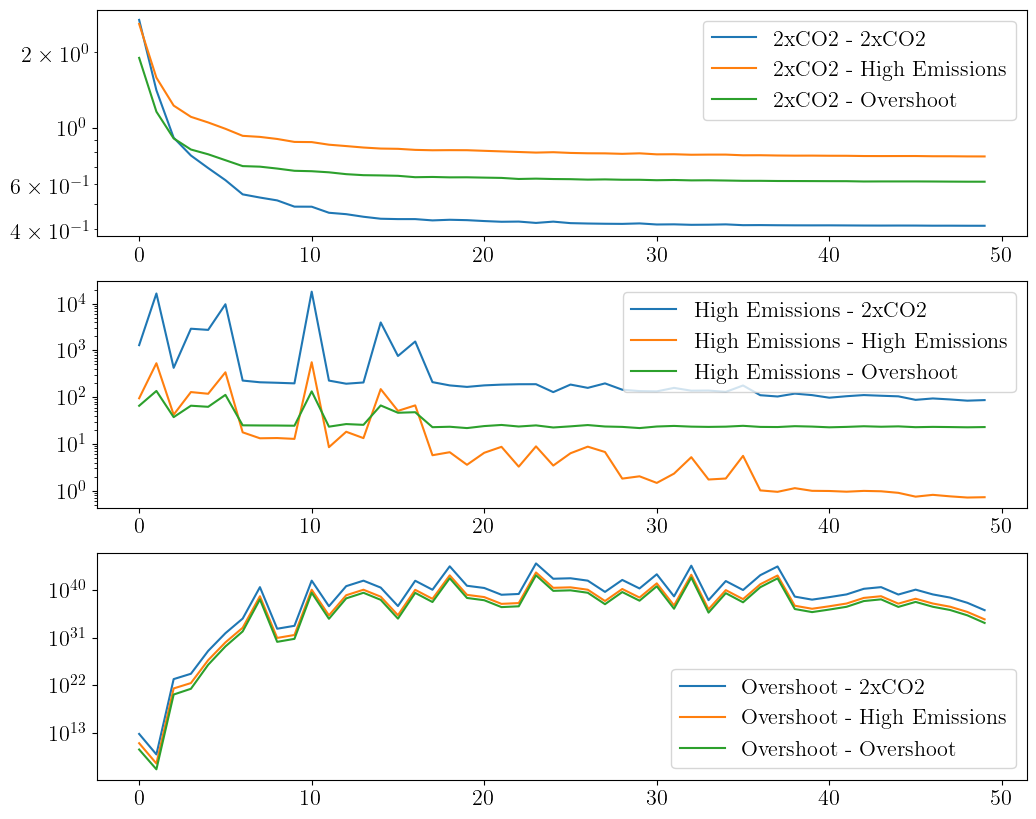

In [110]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_DMD[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: EDMD

In [96]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=2)
operator_EDMD, T_pred_EDMD, L2_EDMD = emulator_utils.emulate_experiments('EDMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
#emulator_utils.plot_true_pred(T_out_single, T_pred_EDMD, experiments)
operator_ensemble_EDMD, operator_L2_avg_EDMD, w_pred_L2_EDMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'EDMD', operator_EDMD, w_dict=w_dict, F_dict=F_dict, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.03777639899673565
	Test: High Emissions - 31.724992273336053
	Test: Overshoot - 8.466815904193886
Train: High Emissions - L2 Error
	Test: 2xCO2 - 6.530845812422882
	Test: High Emissions - 0.000584964372393583
	Test: Overshoot - 3.2525754118743997
Train: Overshoot - L2 Error
	Test: 2xCO2 - 25.13576447292698
	Test: High Emissions - 0.823842701076929
	Test: Overshoot - 0.00042836198351444067


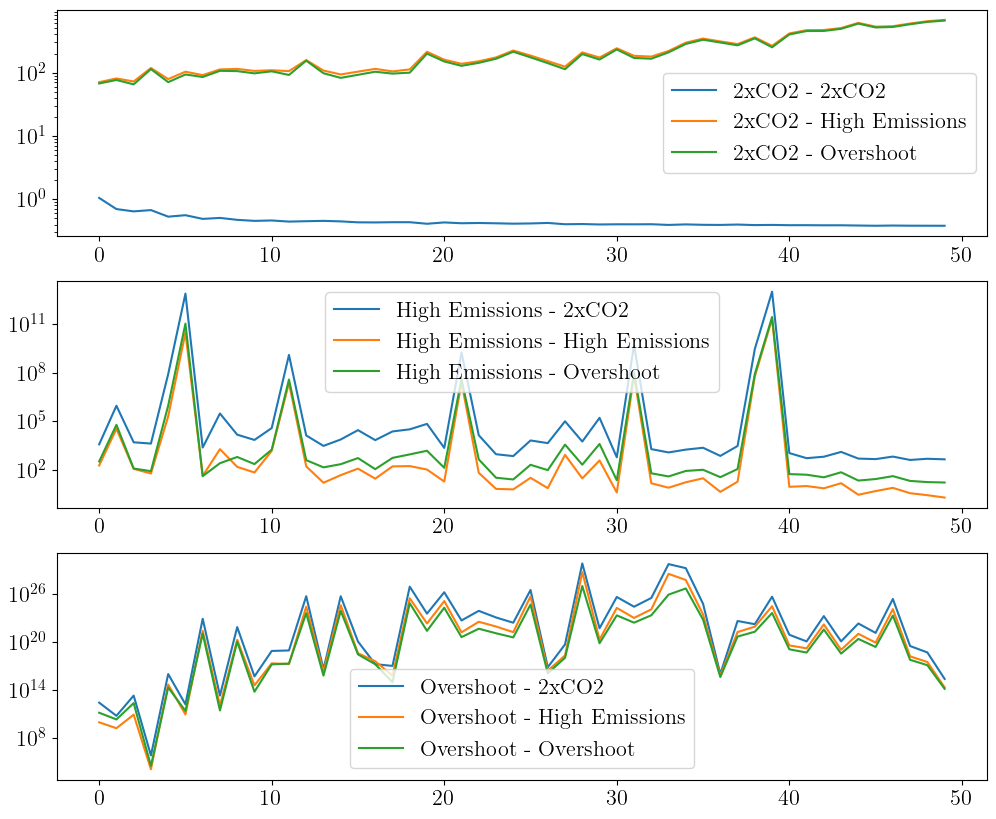

In [109]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_EDMD[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: Deconvolution

In [41]:
x = emulator_utils.get_regularization(T_out_ensemble['High Emissions'][0], forcings_ensemble['High Emissions'][0])

/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [43]:
#x = emulator_utils.get_regularization(T_out_single['High Emissions'], forcings_single['High Emissions'])
G_test = emulator_utils.method_3a_deconvolve(T_out_ensemble['High Emissions'][0], forcings_ensemble['High Emissions'][0], 1, regularize=False)
G_test2 = emulator_utils.method_3a_deconvolve(T_out_ensemble['High Emissions'][0], forcings_ensemble['High Emissions'][0], 1, regularize=True)

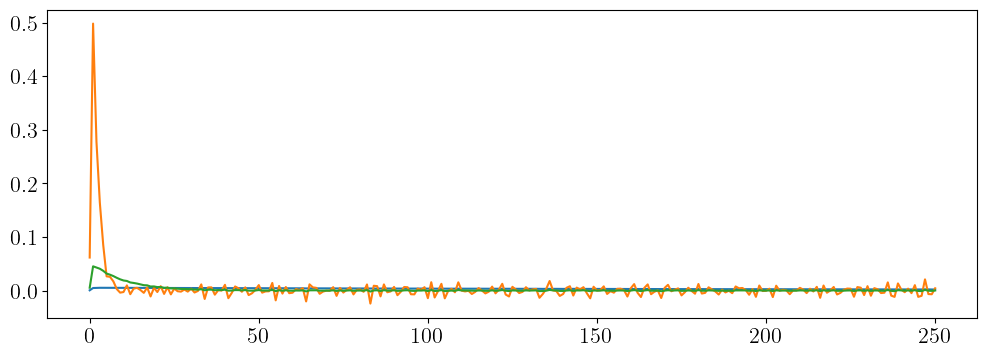

In [128]:
plt.plot(operator_ensemble_deconvolve['2xCO2'][30].T)
#plt.plot(G_test2.T)

In [118]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, L2_deconvolve = emulator_utils.emulate_experiments('deconvolve', experiments=experiments, outputs=T_out_single, forcings=forcings_single, dt=dt)
#emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, experiments)
operator_ensemble_deconvolve, operator_L2_avg_deconvolve, w_pred_L2_deconvolve = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'deconvolve', operator_deconvolve, dt=dt)


Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 2.13308779473121e-14
	Test: High Emissions - 0.565307660478443
	Test: Overshoot - 0.35421144543522953
Train: High Emissions - L2 Error
	Test: 2xCO2 - 0.8753618633080136
	Test: High Emissions - 3.1024171503776466e-14
	Test: Overshoot - 0.5472872401232058
Train: Overshoot - L2 Error
	Test: 2xCO2 - 972431.3764607814
	Test: High Emissions - 16018.89210791696
	Test: Overshoot - 4.4099480565561345e-14


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


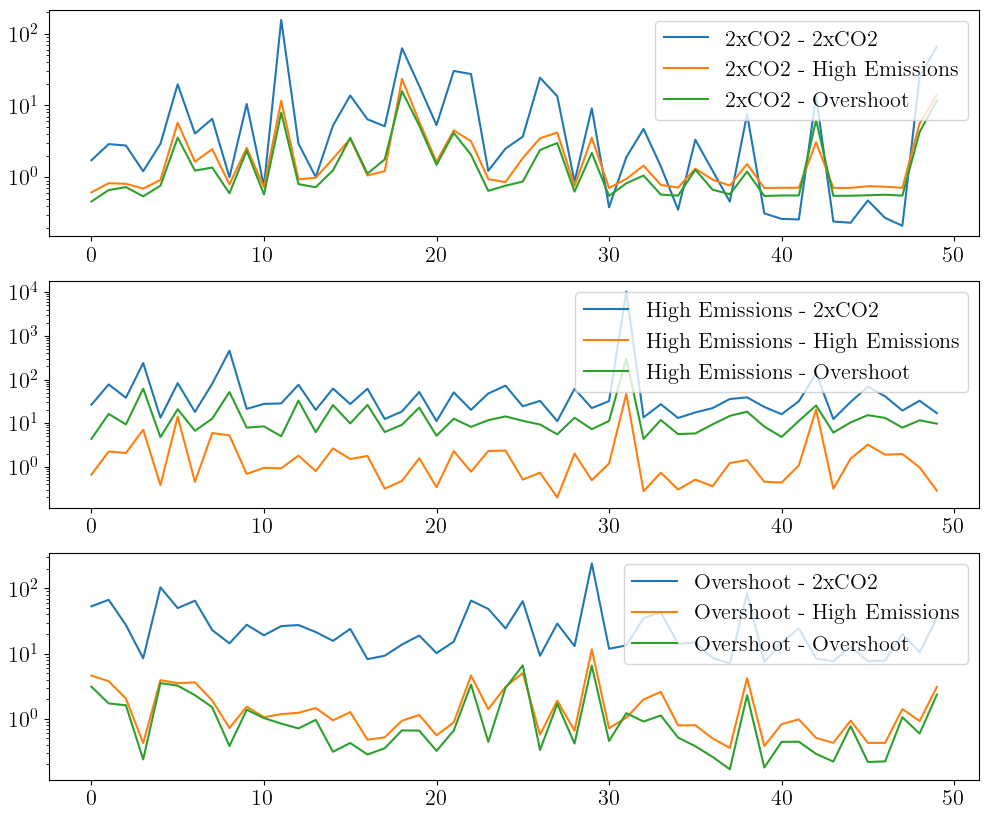

In [119]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
for i, exp1 in enumerate(experiments):
  for exp2 in experiments:
    ax[i].semilogy(w_pred_L2_deconvolve[exp1][exp2], label=f'{exp1} - {exp2}')
  ax[i].legend()

### Method X: Direct Diagnosis

In [193]:
n_ensemble = 50
operator_direct, T_pred_direct, L2_direct = emulator_utils.emulate_experiments('direct', experiments=experiments, outputs=T_out_single, forcings=forcings_single, n_boxes=n_boxes, dt=dt)
#emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, experiments)
operator_ensemble_direct, operator_L2_avg_direct = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'direct', operator_direct, t=t, dt=dt, n_boxes=n_boxes, xi=xi)

100%|██████████| 22827/22827 [00:00<00:00, 33474.50it/s]


Train: Impulse Forcing - L2 Error
	Test: 2xCO2 - 1.5730398636794063
	Test: High Emissions - 0.26961399061701136
	Test: Overshoot - 0.9335296520994525


100%|██████████| 22827/22827 [00:00<00:00, 35798.25it/s]
/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:299: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  def Run_Budyko_Sellers(exp_flag=0, diff_flag=0, vert_diff_flag=0, xi=0):
100%|██████████| 22827/22827 [00:00<00:00, 35131.16it/s]


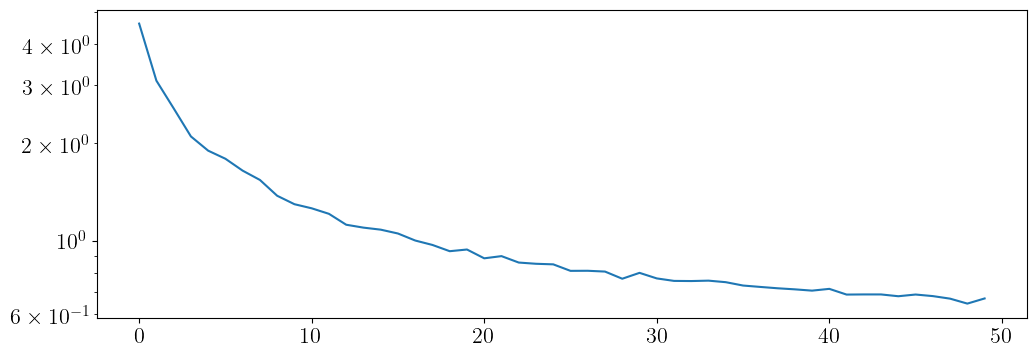

In [194]:
plt.semilogy(operator_L2_avg_direct, label=exp)

### Method X: FDT

In [161]:
#### DO NOT USE
delta = 2
operator_ensemble_FDT, operator_L2_avg_FDT, w_pred_L2_FDT = emulator_utils.evaluate_ensemble(experiments, 5, n_choices, forcings_ensemble, T_out_ensemble, 'FDT', operator_deconvolve, dt=dt, delta=delta, n_boxes=n_boxes, n_steps=n_steps, xi=xi)

/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  return out


In [165]:
n_ensemble = 10
operator_FDT, T_pred_FDT, L2_FDT = [], [], []
delta = 2
for n in range(1,n_ensemble + 1):
  operator_FDT_n, T_pred_FDT_n, L2_FDT_n = emulator_utils.emulate_experiments('FDT', experiments=experiments, forcings=forcings_single, outputs=T_out_single, n_ensemble=n, n_boxes=n_boxes, n_steps=n_steps, xi=xi, delta=delta, dt=dt)

  operator_FDT.append(operator_FDT_n)
  T_pred_FDT.append(T_pred_FDT_n)
  L2_FDT.append(L2_FDT_n)

Train: 2xCO2 - L2 Error


/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:320: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  return out


	Test: 2xCO2 - 6.105202129172749
	Test: High Emissions - 0.8189527407193754
	Test: Overshoot - 0.41628931210074466
Train: High Emissions - L2 Error
	Test: 2xCO2 - 15.729074358003318
	Test: High Emissions - 8.999581006100168
	Test: Overshoot - 8.153655579428296
Train: Overshoot - L2 Error
	Test: 2xCO2 - 7.443822986997935
	Test: High Emissions - 3.7221434140379377
	Test: Overshoot - 2.9322912358806814
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 10.248279994183717
	Test: High Emissions - 5.951705554747681
	Test: Overshoot - 5.083551179659436
Train: High Emissions - L2 Error
	Test: 2xCO2 - 12.415722566145913
	Test: High Emissions - 7.928170317001427
	Test: Overshoot - 6.602109907688589
Train: Overshoot - L2 Error
	Test: 2xCO2 - 4.749899309501828
	Test: High Emissions - 2.267831775389762
	Test: Overshoot - 1.4843134350406406
Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 12.464279517866412
	Test: High Emissions - 7.050095175317261
	Test: Overshoot - 6.369519130715031
Train: High Emissions - L2 Error
	Te

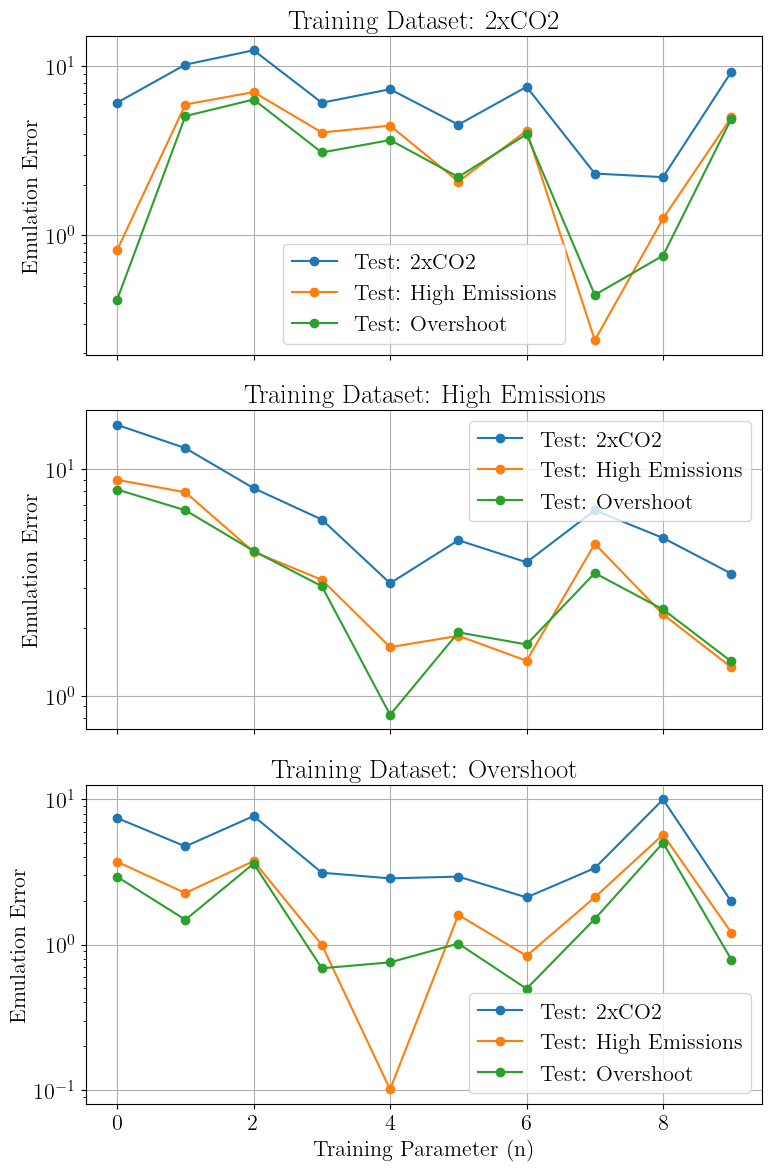

In [168]:
# Number of subplots
num_subplots = len(experiments)
n_values = np.arange(len(L2_FDT))  # Indices represent the training parameter n

# Create subplots
fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 4 * num_subplots), sharex=True)

if num_subplots == 1:
  axes = [axes]  # Ensure axes is iterable if there's only one subplot

for i, exp1 in enumerate(experiments):
  ax = axes[i]
  for exp2 in experiments:
    errors = [entry[exp1][exp2] for entry in L2_FDT]
    ax.semilogy(n_values, errors, marker='o', label=f'Test: {exp2}')

  ax.set_title(f'Training Dataset: {exp1}')
  ax.set_ylabel('Emulation Error')
  ax.legend()
  ax.grid(True)

# Common x-axis label
axes[-1].set_xlabel('Training Parameter (n)')

# Show plot
plt.tight_layout()
plt.show()

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [  42.58759338  363.40770065  -13.17022061 -124.72538597  -33.83855197
 -297.03581553   -0.78137829   -0.78017135]
	Test: 2xCO2 - 14.823548379663473
	Test: High Emissions - 11.208183857646254
	Test: Overshoot - 8.881378895354436
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.53610006 -0.02327916  1.57196556  0.71754098  0.02476957  0.6718183
 -0.5829879  -0.92518196]
	Test: 2xCO2 - 21.762411623972977
	Test: High Emissions - 0.12952741822841052
	Test: Overshoot - 5.4937209786066115
Train: Overshoot - L2 Error
Exponential Fit Results:
 [ 0.35042857  0.16105175  1.43693308  0.60390633  0.62050815  0.23902337
 -0.93020788 -0.2986362 ]
	Test: 2xCO2 - 19.26846545600725
	Test: High Emissions - 3.2565744387932836
	Test: Overshoot - 4.864326045514617


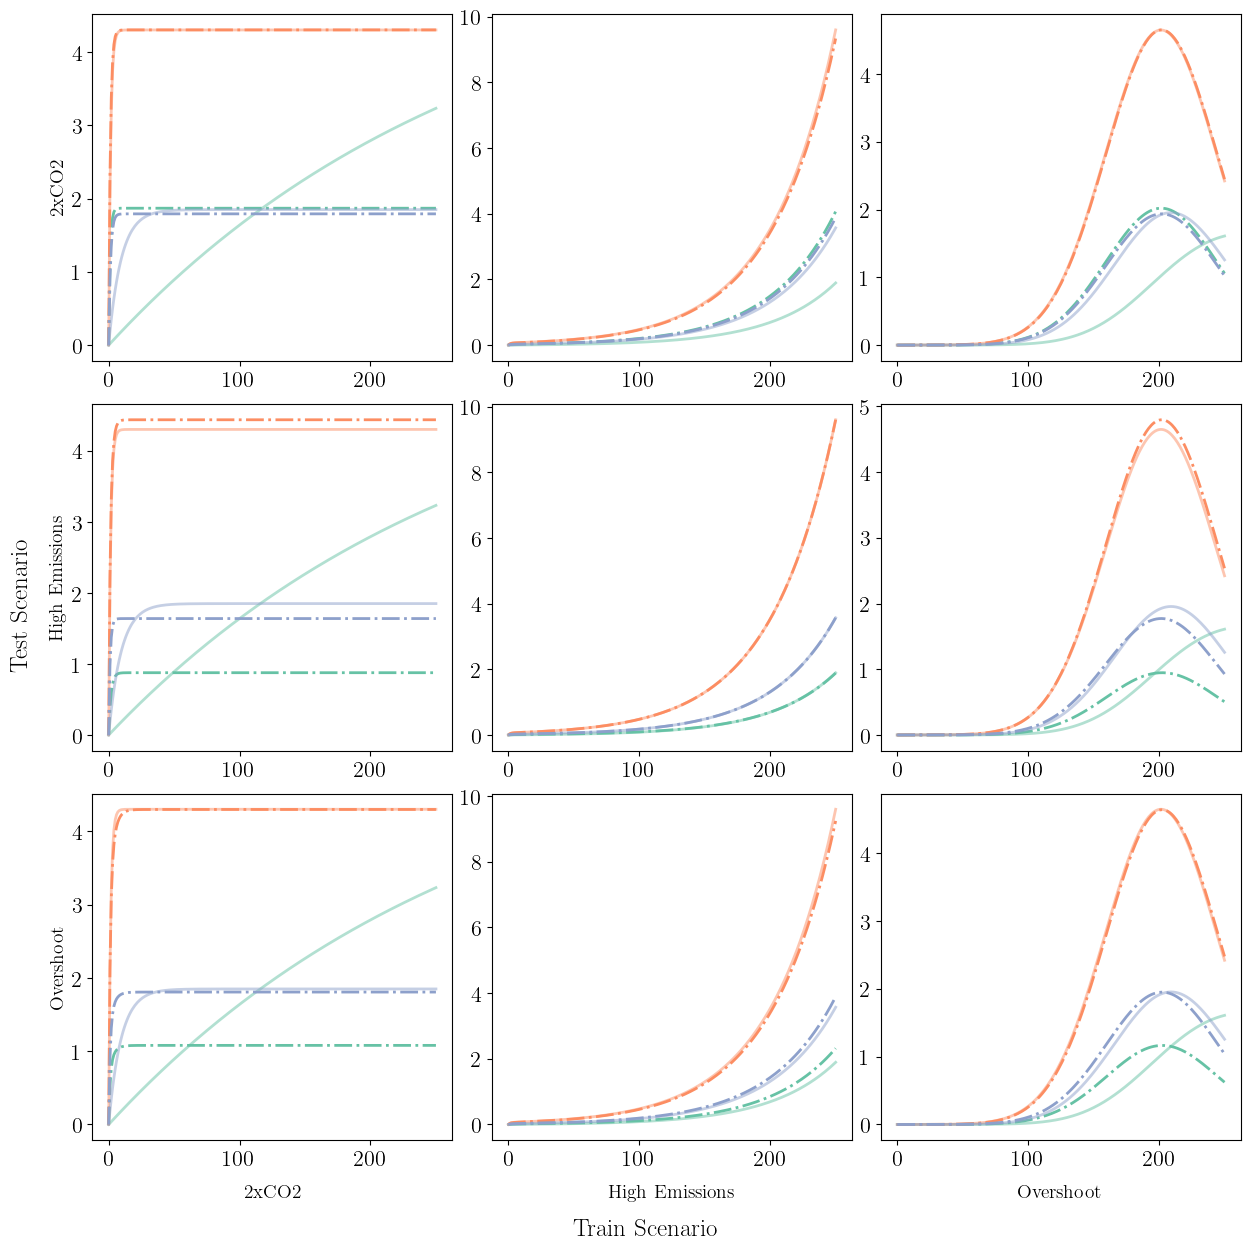

In [221]:
operator_fit, T_pred_fit = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'fit', w0, t, dt, n_steps, n_boxes, n_modes=2)
emulator_utils.plot_true_pred(T_out, T_pred_fit, experiments)